# 🐢 Turtles sightings 🐢
This notebooks illustrates the computation of a heatmap using observation locations. 

Dataset: 
> Marine Turtles	National Biodiversity Network Trust. Marine Turtles. National Biodiversity Network Trust, Newark, UK.      
https://doi.org/10.15468/fyt9hw,       
https://portal.obis.org/dataset/1cfc4d23-9fcd-42b2-95bf-9c4ee9bc50f6

In [21]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using Statistics
using DelimitedFiles
using LinearAlgebra
using Random
include("../config.jl")

LoadError: InitError: could not load library "/home/ctroupin/.julia/artifacts/43964d8fde379b95f9b4bdc214b688bc394cd4ac/lib/libgio-2.0.so"
/home/ctroupin/.julia/artifacts/43964d8fde379b95f9b4bdc214b688bc394cd4ac/lib/libgobject-2.0.so.0: undefined symbol: g_dir_unref
during initialization of module Glib_jll

## Read the data retrieved from OBIS

In [22]:
download_check(turtlefile, turtlefileURL)
AA = readdlm(turtlefile)
@show size(AA);

LoadError: UndefVarError: `download_check` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [3]:
lon=AA[:,1]
lat=AA[:,2]
@ifno mean(lon), mean(lat)

(-6.812426180783882, 52.77852833638372)

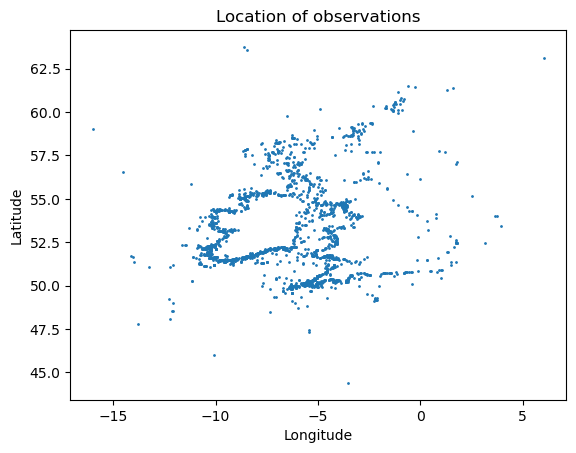

PyObject Text(0.5, 1.0, 'Location of observations')

In [4]:
scatter(lon,lat,s=1)
xlabel("Longitude")
ylabel("Latitude")
title("Location of observations")

## Simple heatmap without land mask

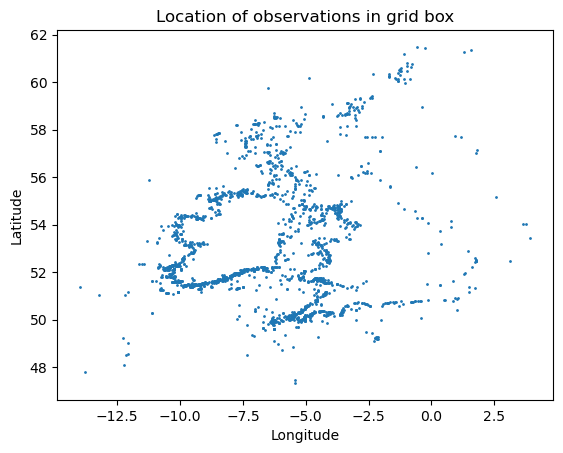

PyObject Text(0.5, 1.0, 'Location of observations in grid box')

In [5]:
NX=300
NY=250
# Box size
LX=18.
LY=15.
# Bounding box
xleft=-14.
ybot=47.
xright=xleft+LX
ytop=ybot+LY

xo=lon
yo=lat

# Eliminate points out of the box
sel=(xo.>xleft) .& (xo.<xright) .& (yo.>ybot) .& (yo.<ytop)

xo=xo[sel]
yo=yo[sel]
inflation=ones(size(xo))
scatter(xo,yo,s=1)
xlabel("Longitude")
ylabel("Latitude")
title("Location of observations in grid box")

### Heatmap

size(xi) = (300, 250)
106.778897 seconds (42.87 M allocations: 56.809 GiB, 3.79% gc time, 17.89% compilation time)
(LCV, LSCV, mean(LHM[1]), mean(LHM[2])) = (-3.6606381501024097, -0.0952064139847272, 2.262294611007301, 1.9585274168759748)


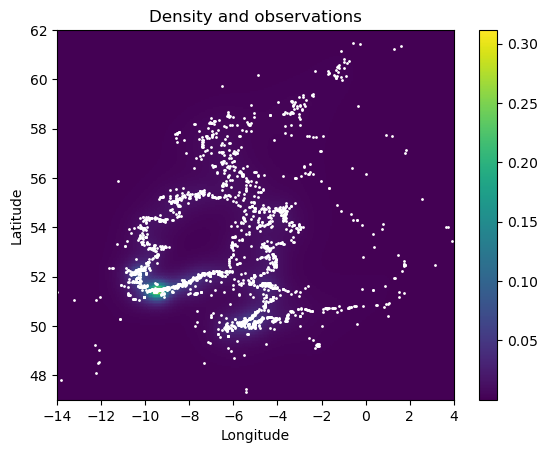

(-3.6606381501024097, -0.0952064139847272, 2.262294611007301, 1.9585274168759748)

In [6]:
dx=LX/(NX)
dy=LY/(NY)

xg = xleft+dx/2:dx:xleft+LX
yg = ybot+dy/2:dy:ybot+LY
# for pyplot
xp=xleft:dx:xleft+LX
yp = ybot:dy:ybot+LY
maskp,(pmp,pnp),(xip,yip) = DIVAnd.DIVAnd_rectdom(xp,yp)

mask,(pm,pn),(xi,yi) = DIVAnd.DIVAnd_rectdom(xg,yg)


# adding a mask
#mask[(xi.+0.25)./0.95 .+ (yi.-2.4)./1.1 .<1 ].=false
#mask[2*xi.+yi .<3.4 ].=false

@show size(xi)
# From here generic approach 
@time dens1,LHM,LCV,LSCV = DIVAnd.DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)

figure()
pcolor(xip,yip,dens1),colorbar()
scatter(xo,yo,s=1,c="white")
xlabel("Longitude")
ylabel("Latitude")
title("Density and observations")
@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

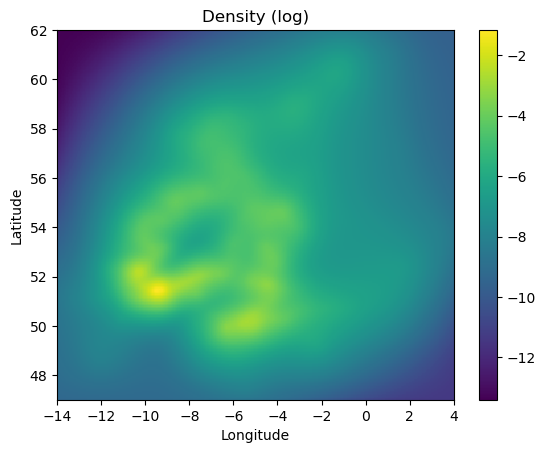

PyObject Text(0.5, 1.0, 'Density (log)')

In [7]:
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("Density (log)")

## Prepare land mask

In [8]:
bathname = gebco

if !isfile(bathname)
    download("https://dox.uliege.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

[ Info: Bathymetry file already downloaded


size(b) = (300, 250)


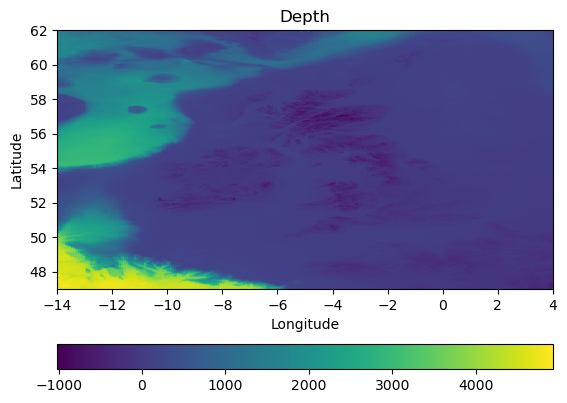

(300, 250)

In [9]:
bx,by,b = load_bath(bathname,true,xg,yg)

pcolor(bx,by,b'); colorbar(orientation="horizontal")
xlabel("Longitude")
ylabel("Latitude")
title("Depth")

@show size(b)

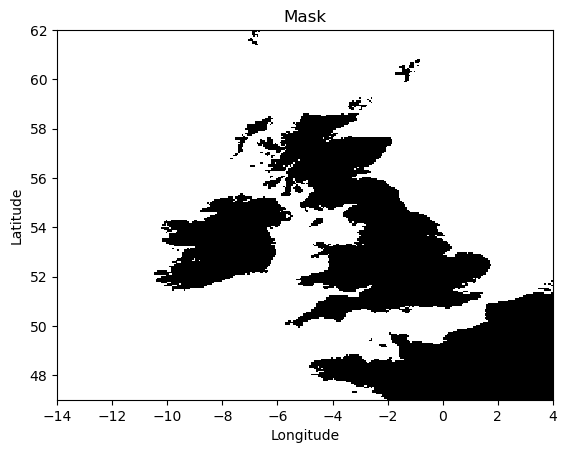

PyObject Text(0.5, 1.0, 'Mask')

In [10]:
for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >= 0
    end
end
pcolor(bx,by,Float64.(mask)', cmap=PyPlot.cm.binary_r)
xlabel("Longitude")
ylabel("Latitude")
title("Mask")

### First heatmap with uniform and automatic bandwidth

 27.473156 seconds (306.39 k allocations: 22.830 GiB, 7.11% gc time, 0.13% compilation time)
(LCV, LSCV, mean(LHM[1]), mean(LHM[2])) = (-4.053192737275814, -0.038475123262984766, 0.7492269243006295, 0.6486252787611434)


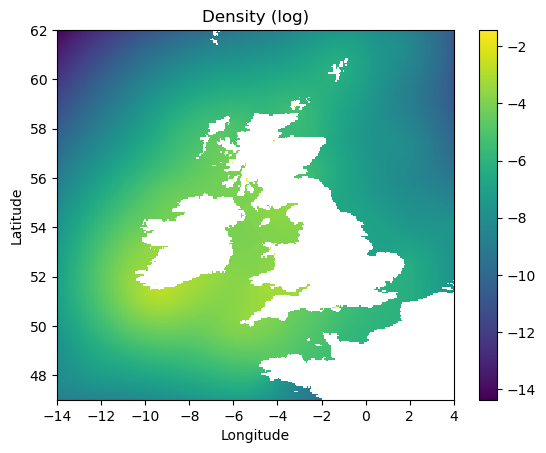

(-4.053192737275814, -0.038475123262984766, 0.7492269243006295, 0.6486252787611434)

In [11]:
@time dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=0)

figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
#scatter(xo,yo,s=1,c="white")
title("Density (log)")
@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

## Now with adapted bandwidth

 52.986443 seconds (578.77 k allocations: 45.668 GiB, 5.54% gc time)
(LCV, LSCV, mean(LHM[1]), mean(LHM[2])) = (-3.297973337917711, -0.20146312385232568, 2.1057658801529398, 1.8096391652735664)


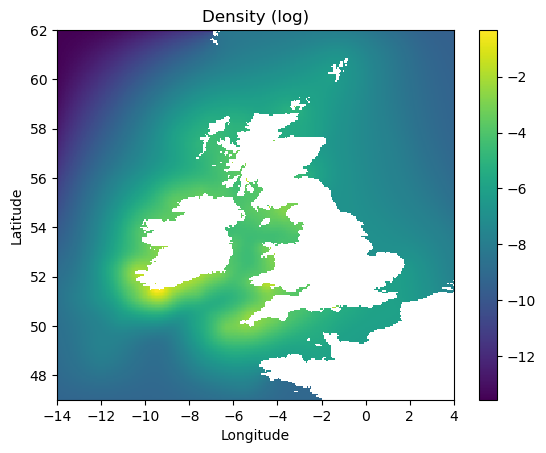

(-3.297973337917711, -0.20146312385232568, 2.1057658801529398, 1.8096391652735664)

In [12]:
@time dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)

figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
#scatter(xo,yo,s=1,c="white")
title("Density (log)")


@show LCV,LSCV,mean(LHM[1]),mean(LHM[2])

### But how much iterations ? Cross validation indicators can help 

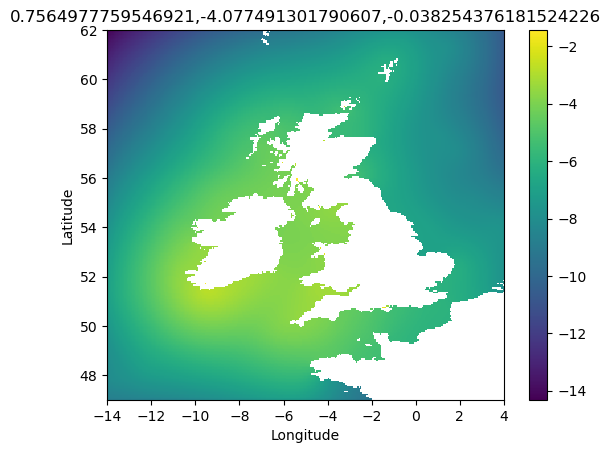

PyObject Text(0.5, 1.0, '0.7564977759546921,-4.077491301790607,-0.038254376181524226')

In [13]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=0)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

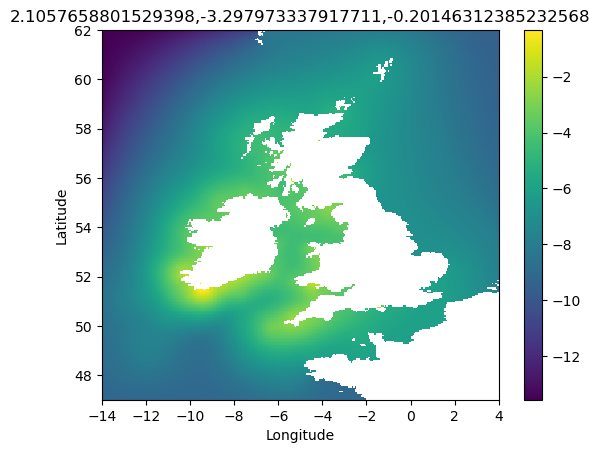

PyObject Text(0.5, 1.0, '2.1057658801529398,-3.297973337917711,-0.20146312385232568')

In [14]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=1)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

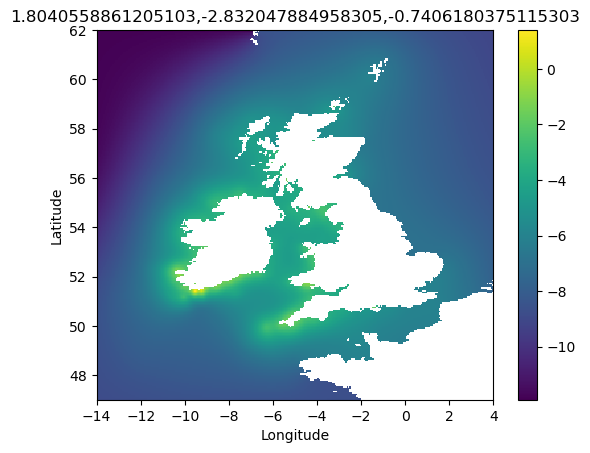

PyObject Text(0.5, 1.0, '1.8040558861205103,-2.832047884958305,-0.7406180375115303')

In [15]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=2)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

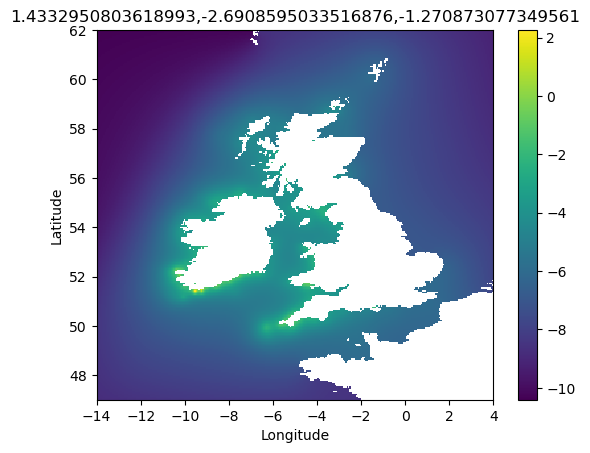

PyObject Text(0.5, 1.0, '1.4332950803618993,-2.6908595033516876,-1.270873077349561')

In [16]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=3)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

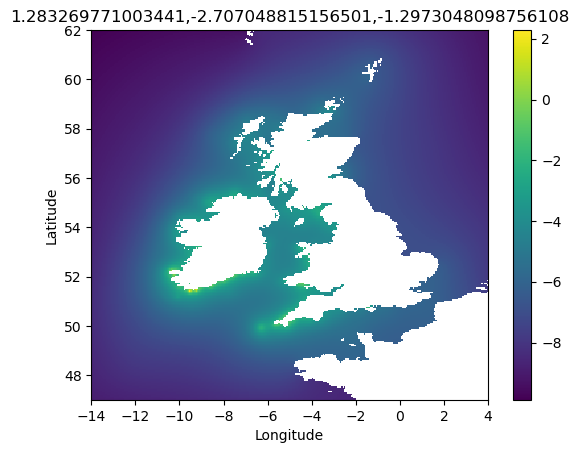

PyObject Text(0.5, 1.0, '1.283269771003441,-2.707048815156501,-1.2973048098756108')

In [17]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=4)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

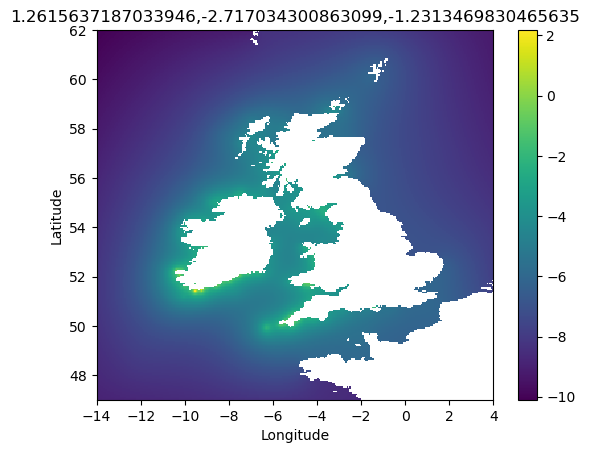

PyObject Text(0.5, 1.0, '1.2615637187033946,-2.717034300863099,-1.2313469830465635')

In [18]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=5)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

## 4 iterations yield highest likelyhood and lowest rms

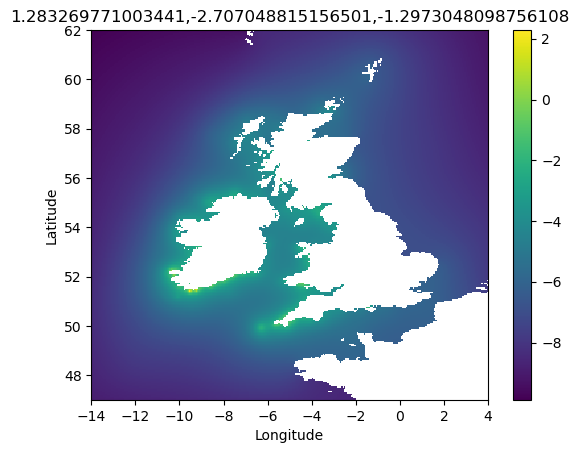

PyObject Text(0.5, 1.0, '1.283269771003441,-2.707048815156501,-1.2973048098756108')

In [19]:
dens1,LHM,LCV,LSCV= DIVAnd_heatmap(mask,(pm,pn),(xi,yi),(xo,yo),inflation,0;Ladaptiveiterations=4)
figure()
pcolormesh(xip,yip,log.(dens1)),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("$(mean(LHM[1])),$LCV,$LSCV")

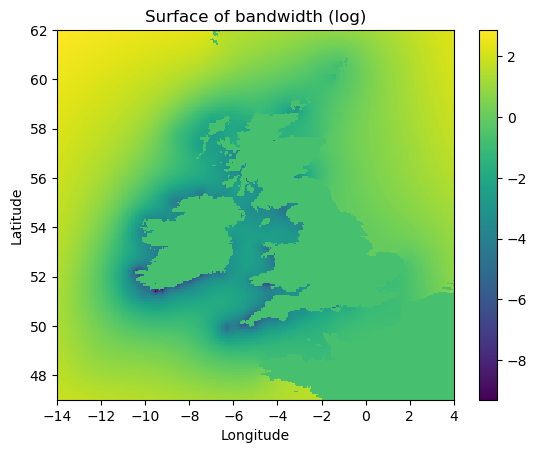

PyObject Text(0.5, 1.0, 'Surface of bandwidth (log)')

In [20]:
pcolormesh(xip,yip,log.(LHM[1].*LHM[2])),colorbar()
xlabel("Longitude")
ylabel("Latitude")
title("Surface of bandwidth (log)")

# Important note

There is no information used on the effort of looking for turtles. Obviously more are seen close to coastlines because of easier spotting.